# Land Use / Land Cover Segmentation Using Sentinel-2 and Random Forest

This workflow demonstrates how to use a [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) [GeoMedian annual satellite imagery composite](https://github.com/digitalearthpacific/dep-geomad) for segmenting land use / land cover (LULC) using a [GPU-accelerated Random Forest classifier](https://developer.nvidia.com/blog/accelerating-random-forests-up-to-45x-using-cuml/). We will pursue this objective by integrating ground truth land use land cover data from the VBoS from 2022. To make this scalable to all of Vanuatu, we use an [administrative boundaries dataset from Pacific data hub](https://pacificdata.org/data/dataset/2016_vut_phc_admin_boundaries/resource/66ae054b-9b67-4876-b59c-0b078c31e800).

In this notebook, we will demonstrate the following:

1. **Data Acquisition**:
   - We use **Sentinel-2 L2A** data accessed via the [Digital Earth Pacific STAC catalog](http://stac.digitalearthpacific.org/). The search is filtered by parameters like a region of interest (AOI) and time range to obtain suitable imagery.
   
2. **Preprocessing**:
   - The Sentinel-2 imagery contains several spectral bands (e.g., Red, Green, Blue, Near-Infrared, Short-wave Infrared). These are extracted and combined into a single dataset for analysis. Remote sensing indices useful for land use / land cover mapping are calculated from these bands. Additionally, the imagery is masked to remove areas outside the regions of interest so as to focus on the relevant pixels. We use 5 out of 6 provinces making up the nation of Vanuatu for training, and one for testing.
  
3. **Feature Extraction**:
   - Features for the classifier are extracted from the Sentinel-2 spectral bands. Here, we will use the reflectance values from the Red, Green, Blue, Near-Infrared (NIR), and Short-wave Infrared (SWIR) bands. We will compute remote sensing indices (NDVI, MNDWI, SAVI, BSI) from these bands as the final feature set.

4. **Ground Truth Data Integration**:
   - A shapefile containing polygons attributed by land cover/land use is loaded into a [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). This allows us to create multi-class labels for the pixels in the Sentinel-2 imagery.
  
5. **Data Splitting**:
   - To ensure correct model training, we split the features and labels into training (80%) and testing (20%) sets. A 'seed' value is used for the random number generator to ensure this random split is reproducible.

6. **Random Forest Classification**:
   - We train a **Random Forest** classifier to predict land use/land cover on a pixel-wise basis. The `n_estimators` parameter is a key hyperparameter, determining the number of decision trees in the forest. Random Forest leverages the collective wisdom of multiple decision trees to make accurate predictions.

7. **Prediction**:
   - We will use the trained classifier to predict the likelihood of lulc types for each pixel in the test image/province. 

8. **Evaluation**:
   - After making predictions on the test partition, we evaluate the model's performance using metrics such as accuracy and F1-score. This allows us to assess the performance of the Random Forest model and the effectiveness of the selected features.

At the end, you will have trained a model to predict land use / land cover in Vanuatu.

In [1]:
!mamba install --channel rapidsai --quiet --yes cuml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 
To enable CUDA support, UCX requires the CUDA Runtime library (libcudart).
The library can be installed with the appropriate command below:

* For CUDA 11, run:    conda install cudatoolkit cuda-version=11
* For CUDA 12, run:    conda install cuda-cudart cuda-version=12

If any of the packages you requested use CUDA then CUDA should already
have been installed for you.


done


In [ ]:
!pip install gdown

In [68]:
import glob
import pickle
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import rasterio.features
import rioxarray as rxr
import xarray as xr
from cuml import RandomForestClassifier
from dask import compute, delayed
from dask_ml.model_selection import train_test_split
from geocube.api.core import make_geocube
from pystac_client import Client
from shapely.geometry import Polygon, box, mapping, shape
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from tqdm import tqdm

## Data Acquisition

Let's read the LULC data into a GeoDataFrame. 

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) is a type of data structure used to store geographic data in Python, provided by the [GeoPandas](https://geopandas.org/en/stable/) library. It extends the functionality of a pandas DataFrame to handle spatial data, enabling geospatial analysis and visualization. Like a pandas DataFrame, a GeoDataFrame is a tabular data structure with labeled axes (rows and columns), but it adds special features to work with geometric objects, such as:
- a geometry column
- a CRS
- accessibility to spatial operations (e.g.  intersection, union, buffering, and spatial joins)

Download the LULC ROI data (e.g. ROIs_v9.zip). 

**IMPORTANT**: If the version changes, please upload it here **manually** and have it **named** like ROIs_v10.zip or ROIs_v11.zip, etc.

In [3]:
# THIS IS A LINK TO DOWNLOAD ROIs_v9.zip ONLY
!gdown "https://drive.google.com/uc?id=1EOBFi26CsyOp-NsZRz6kFsbqy98KugME"

Downloading...
From: https://drive.google.com/uc?id=1EOBFi26CsyOp-NsZRz6kFsbqy98KugME
To: /home/jovyan/depal/ROIs_v9.zip
100%|████████████████████████████████████████| 146k/146k [00:00<00:00, 7.61MB/s]


In [ ]:
# Download the administrative boundaries (2016_phc_vut_pid_4326.geojson)
!wget https://pacificdata.org/data/dataset/9dba1377-740c-429e-92ce-6a484657b4d9/resource/3d490d87-99c0-47fd-98bd-211adaf44f71/download/2016_phc_vut_pid_4326.geojson

Read and inspect the datasets. Set the ROI version of your dataset here.

In [70]:
ROI_version = 9

In [71]:
lulc_gdf = gpd.read_file(f"ROIs_v{ROI_version}.zip")

In [5]:
lulc_gdf

,ROI,PID,Pname,AC2022,ACNAME22,geometry
0,Water Bodies,2.0,SANMA,211,Bigbay Inland,"POLYGON Z ((166.92126 -15.22911 0, 166.92212 -..."
1,Water Bodies,2.0,SANMA,211,Bigbay Inland,"POLYGON Z ((166.92365 -15.2306 0, 166.92412 -1..."
2,Water Bodies,2.0,SANMA,211,Bigbay Inland,"POLYGON Z ((166.92722 -15.23548 0, 166.92776 -..."
3,Water Bodies,2.0,SANMA,207,Canal - Fanafo,"POLYGON Z ((167.14639 -15.46674 0, 167.14647 -..."
4,Water Bodies,2.0,SANMA,207,Canal - Fanafo,"POLYGON Z ((167.14756 -15.46784 0, 167.14744 -..."
...,...,...,...,...,...,...
1584,Builtup Infrastructure,6.0,TAFEA,605,West Tanna,"POLYGON Z ((169.28104 -19.5413 0, 169.28116 -1..."
1585,Builtup Infrastructure,6.0,TAFEA,605,West Tanna,"POLYGON Z ((169.2814 -19.54204 0, 169.28141 -1..."
1586,Builtup Infrastructure,6.0,TAFEA,605,West Tanna,"POLYGON Z ((169.28116 -19.54239 0, 169.28116 -..."
1587,Builtup Infrastructure,6.0,TAFEA,605,West Tanna,"POLYGON Z ((169.28097 -19.54255 0, 169.28096 -..."


In [6]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_pid_4326.geojson")

In [7]:
admin_boundaries_gdf

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
2,3,PENAMA,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
3,4,MALAMPA,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
5,6,TAFEA,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [8]:
len(lulc_gdf), len(admin_boundaries_gdf)

(1589, 6)

We can check out the attributes associated with this dataset:

In [9]:
lulc_gdf.columns

Index(['ROI', 'PID', 'Pname', 'AC2022', 'ACNAME22', 'geometry'], dtype='object')

Let's see which classes are available to us in the most recent LULC column.

In [10]:
lulc_gdf.ROI.unique()

array(['Water Bodies', 'Coconut Plantations', 'Grassland', 'Mangroves',
       'Agriculture', 'Barelands', 'Builtup Infrastructure',
       'Dense_Forest', 'Open_Forest'], dtype=object)

And view a subset of the data (shuffled for more variety in the 10 samples):

In [9]:
lulc_gdf.sample(frac=1).head(10)

,ROI,PID,Pname,AC2022,ACNAME22,geometry
1215,Barelands,6.0,TAFEA,607,South West Tanna,"POLYGON Z ((169.3932 -19.64304 0, 169.39326 -1..."
915,Open_Forest,5.0,SHEFA,517,Eratap,"POLYGON Z ((168.39316 -17.75002 0, 168.39256 -..."
247,Mangroves,2.0,SANMA,205,East Santo,"POLYGON Z ((167.07264 -15.03854 0, 167.07284 -..."
13,Water Bodies,2.0,SANMA,207,Canal - Fanafo,"POLYGON Z ((167.15953 -15.50409 0, 167.16035 -..."
785,Dense_Forest,5.0,SHEFA,518,Eton,"POLYGON Z ((168.46559 -17.61546 0, 168.46564 -..."
68,Water Bodies,6.0,TAFEA,601,North Erromango,"POLYGON Z ((169.16083 -18.7328 0, 169.16096 -1..."
251,Mangroves,2.0,SANMA,205,East Santo,"POLYGON Z ((167.07169 -15.0383 0, 167.07185 -1..."
1295,Builtup Infrastructure,2.0,SANMA,205,East Santo,"POLYGON Z ((167.14626 -15.25678 0, 167.14631 -..."
732,Dense_Forest,5.0,SHEFA,516,Erakor,"POLYGON Z ((168.3732 -17.70327 0, 168.3732 -17..."
1421,Coconut Plantations,5.0,SHEFA,518,Eton,"POLYGON Z ((168.49684 -17.81635 0, 168.49615 -..."


Let's calculate total area of each ROI class for each province. To do this, we first need to reproject our ROIs to a projection with units in meters.

In [11]:
# original projection in units of degrees
lulc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# convert to a projection with units in meters that is appropriate for Vanuatu
lulc_gdf_meters = lulc_gdf.to_crs(epsg="32759") # WGS 84 / UTM zone 59S

In [13]:
lulc_gdf_meters.crs

<Projected CRS: EPSG:32759>
Name: WGS 84 / UTM zone 59S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 168°E and 174°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (168.0, -80.0, 174.0, 0.0)
Coordinate Operation:
- name: UTM zone 59S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Aggregate by ROI class and province. Calculate total area for ROI classes in each province. Save to a CSV file, which will be located in the current working directory on this machine. You can download it from the DEP file system.

In [12]:
lulc_gdf_meters.dissolve(by=["ROI", "Pname"]).area.to_csv("Vanuatu_ROIs.csv")

View what we just did, but simply within the notebook instead of in the CSV we created above.

In [13]:
lulc_gdf_meters.dissolve(by=["ROI", "Pname"]).area

ROI                     Pname  
Agriculture             MALAMPA    9.314003e+05
                        SANMA      8.698804e+04
                        SHEFA      1.498451e+06
                        TAFEA      4.728793e+04
Barelands               MALAMPA    8.375871e+05
                        PENAMA     7.587322e+05
                        SANMA      6.125466e+04
                        SHEFA      7.758676e+04
                        TAFEA      4.419720e+05
                        TORBA      2.221881e+03
Builtup Infrastructure  MALAMPA    6.691879e+03
                        SANMA      6.322595e+04
                        SHEFA      8.941033e+04
                        TAFEA      2.070150e+04
Coconut Plantations     MALAMPA    2.174810e+05
                        PENAMA     4.243836e+03
                        SANMA      3.416615e+05
                        SHEFA      1.324301e+05
                        TORBA      2.791212e+04
Dense_Forest            SHEFA      9.806312e+05
        

Get our province names and year associated with our ROIs.

In [15]:
YEAR = 2020 # year matching label data 
PROVINCES_TRAIN = ["TORBA", "SANMA", "PENAMA", "MALAMPA", "TAFEA", "SHEFA"] # all provinces

In [16]:
admin_boundaries_gdf = admin_boundaries_gdf.set_index(keys="pname")  # set province name as the index

Get geometries of each province.

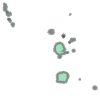

In [20]:
GEOMS_TRAIN = admin_boundaries_gdf.loc[PROVINCES_TRAIN].geometry.tolist()
GEOMS_TRAIN[0]

Get [Sentinel-2 GeoMedian composite data](https://maps.digitalearthpacific.org/#share=s-9lCm2kZsa4Sf3EhSV80x) for the selected year for each province.

In [23]:
STAC_URL = "http://stac.digitalearthpacific.org/"
stac_client = Client.open(STAC_URL)

In [26]:
# Collect s2_data per train province in a list
s2_data_train_list = []

for pname, geom in tqdm(zip(PROVINCES_TRAIN, GEOMS_TRAIN), total=len(GEOMS_TRAIN), desc="Loading GeoMAD per province"):
    try:
        # Query STAC for this province
        s2_search = stac_client.search(
            collections=["dep_s2_geomad"], # Sentinel-2 Geometric Median and Absolute Deviations (GeoMAD) over the Pacific.
            intersects=mapping(geom),  # GeoJSON dict
            datetime=str(YEAR),
        )
        s2_items = s2_search.item_collection()

        if len(s2_items) == 0:
            print(f"No items found for {pname}")
            continue

        # Load data from items
        s2_data = odc.stac.load(
            items=s2_items,
            bands=["blue", "green", "red", "nir08", "swir16"],
            chunks={"x": 1024, "y": 1024, "bands": -1, "time": -1},
            crs="EPSG:32759",
            resolution=20,
        )

        s2_data_train_list.append(s2_data)

    except Exception as e:
        print(f"Error loading {pname}: {e}")



Loading GeoMAD per province: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Buffer the geometries to include some coastal offshore areas to account for any classes/ROIs that might be relevant and overlapping.

In [27]:
# Should be the same projection as use dearlier (WGS 84 / UTM zone 59S) with units in meters
s2_data_train_list[0].rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]')

In [30]:
lulc_gdf_meters.Pname.unique()

array(['SANMA', 'MALAMPA', 'TORBA', 'SHEFA', 'TAFEA', 'PENAMA'],
      dtype=object)

In [31]:
# Create a dictionary of buffered geometries per province
admin_boundaries_gdf_meters = admin_boundaries_gdf.to_crs(crs=s2_data_train_list[0].rio.crs)

geom_buffered_train = {
    pname: admin_boundaries_gdf_meters.loc[pname].geometry.buffer(5) # minimal; 5 meters only
    for pname in PROVINCES_TRAIN
}

In [32]:
geom_train_buffered_list = list(geom_buffered_train.values())
geom_train_buffered_list

[<MULTIPOLYGON (((180200.094 8401446.407, 180200.112 8401446.413, 180211.731 ...>,
 <MULTIPOLYGON (((100230.221 8275569.268, 100278.697 8275622.839, 100279.122 ...>,
 <MULTIPOLYGON (((192364.986 8277883.84, 192377.791 8277903.364, 192378.062 8...>,
 <MULTIPOLYGON (((218813.501 8173184.471, 218816.957 8173122.002, 218816.961 ...>,
 <MULTIPOLYGON (((415837.973 7840613.624, 415823.762 7840618.847, 415823.322 ...>,
 <MULTIPOLYGON (((249188.583 8119162.965, 249209.503 8119182.556, 249209.843 ...>]

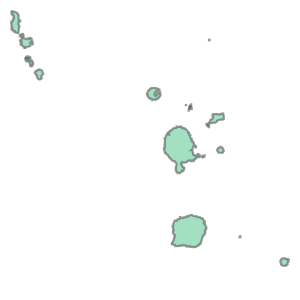

In [33]:
geom_train_buffered_list[0]

Clip the Sentinel-2 data to be within the buffered geometries only.

In [34]:
# Make sure the keys match — we'll zip province names, geometries, and s2 datasets
s2_train_clipped_list = []

for pname, geom, s2_data in zip(PROVINCES_TRAIN, geom_buffered_train.values(), s2_data_train_list):
    try:
        # Clip the dataset to the buffered province geometry
        s2_clipped = s2_data.rio.clip(
            geometries=[mapping(geom)],
            crs=s2_data.rio.crs,
            drop=True
        )
        s2_train_clipped_list.append(s2_clipped)
    except Exception as e:
        print(f"Error clipping data for {pname}: {e}")

In [35]:
s2_train_clipped_list[0]

<xarray.Dataset> Size: 643MB
Dimensions:      (y: 7676, x: 8369, time: 1)
Coordinates:
  * y            (y) float64 61kB 8.551e+06 8.55e+06 ... 8.397e+06 8.397e+06
  * x            (x) float64 67kB 1.651e+04 1.653e+04 ... 1.838e+05 1.839e+05
  * time         (time) datetime64[ns] 8B 2020-01-01
    spatial_ref  int64 8B 0
Data variables:
    blue         (time, y, x) uint16 128MB dask.array<chunksize=(1, 501, 989), meta=np.ndarray>
    green        (time, y, x) uint16 128MB dask.array<chunksize=(1, 501, 989), meta=np.ndarray>
    red          (time, y, x) uint16 128MB dask.array<chunksize=(1, 501, 989), meta=np.ndarray>
    nir08        (time, y, x) uint16 128MB dask.array<chunksize=(1, 501, 989), meta=np.ndarray>
    swir16       (time, y, x) uint16 128MB dask.array<chunksize=(1, 501, 989), meta=np.ndarray>

In [37]:
# Plot sample train province
s2_rgb = s2_train_clipped_list[0][["red", "green", "blue"]] 
s2_rgb_array = s2_rgb.to_array("band")  # now dims: band, y, x
s2_rgb_array_squeezed = s2_rgb_array.squeeze(dim="time", drop=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


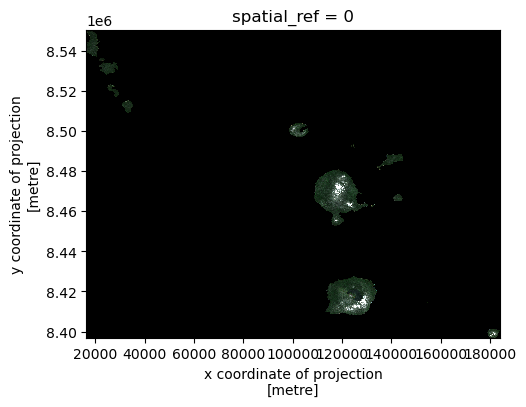

In [38]:
s2_rgb_array_squeezed.plot.imshow(size=4, vmin=0, vmax=4000)

Calculate remote sensing indices.

In [40]:
# Calculate remote sensing indices useful for mapping LULC
def compute_indices(ds):
    red = ds["red"]
    green = ds["green"]
    blue = ds["blue"]
    nir = ds["nir08"]
    swir = ds["swir16"]
    eps = 1e-6
    return xr.Dataset({
        "NDVI": (nir - red) / (nir + red + eps),
        "MNDWI": (green - swir) / (green + swir + eps),
        "SAVI": ((nir - red) / (nir + red + 0.5 + eps)) * 1.5,
        "BSI": ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + eps),
        "NDBI": (swir - nir) / (swir + nir + eps),
    })

index_data_train_list = []

for s2_clipped in s2_train_clipped_list:
    index_data = compute_indices(s2_clipped).squeeze("time", drop=True)
    index_data_train_list.append(index_data)

Rasterize labels from the ROIs for training.

In [41]:
# Rasterize labels
rasterized_labels_train_dict = {}
gdf_train_clipped_dict = {}
metadata_dict = {}

for s2_clipped_train, pname in zip(s2_train_clipped_list, PROVINCES_TRAIN):
    print(f"\n Processing province: {pname}")

    # Sentinel-2 metadata
    width = s2_clipped_train.sizes['x']
    height = s2_clipped_train.sizes['y']
    resolution = s2_clipped_train.rio.resolution()
    bounds = s2_clipped_train.rio.bounds()
    epsg = s2_clipped_train.rio.crs.to_epsg()
    raster_bounds = box(*bounds)

    # Class mapping (safe per-province if needed)
    unique_classes = lulc_gdf_meters['ROI'].unique()
    #class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}
    class_mapping = {cls: i for i, cls in enumerate(unique_classes)} # zero-based, assumes existence of no data    
    lulc_gdf_meters['ROI_numeric'] = lulc_gdf_meters['ROI'].map(class_mapping)

    # Clip vector LULC to S2 bounds
    gdf_train_clipped = lulc_gdf_meters[lulc_gdf_meters.intersects(raster_bounds)]
    print(f"Vector features: {len(lulc_gdf_meters)} → Clipped: {len(gdf_train_clipped)}")

    if len(gdf_train_clipped) == 0:
        print(f"No vector data found for province: {pname}, skipping rasterization.")
        continue

    # Rasterize clipped vector labels
    rasterized_labels_train = make_geocube(
        vector_data=gdf_train_clipped,
        measurements=["ROI_numeric"],
        like=s2_clipped_train
    )

    # Store outputs
    rasterized_labels_train_dict[pname] = rasterized_labels_train
    gdf_train_clipped_dict[pname] = gdf_train_clipped
    metadata_dict[pname] = {
        "width": width,
        "height": height,
        "epsg": epsg,
        "resolution": resolution,
        "bounds": bounds,
        "class_mapping": class_mapping
    }


 Processing province: TORBA
Vector features: 1589 → Clipped: 63

 Processing province: SANMA
Vector features: 1589 → Clipped: 262

 Processing province: PENAMA
Vector features: 1589 → Clipped: 44

 Processing province: MALAMPA
Vector features: 1589 → Clipped: 191

 Processing province: TAFEA
Vector features: 1589 → Clipped: 251

 Processing province: SHEFA
Vector features: 1589 → Clipped: 789


Let's plot the bounds of one province and the ROI polygons that fall within it. Notice how sparse the ROI labels are.

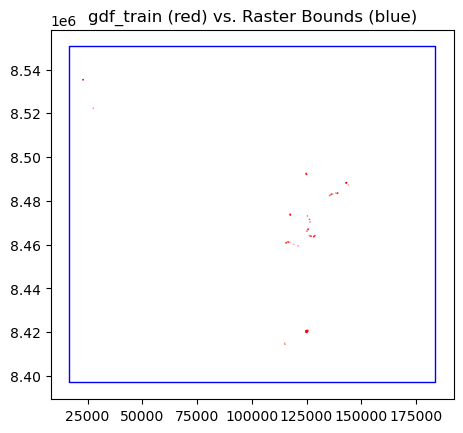

In [42]:
fig, ax = plt.subplots()
gdf_train_clipped_dict["TORBA"].plot(ax=ax, facecolor="none", edgecolor="red")
bbox = box(*s2_train_clipped_list[0].rio.bounds())
gpd.GeoSeries([bbox], crs=s2_train_clipped_list[0].rio.crs).plot(ax=ax, facecolor="none", edgecolor="blue")
plt.title("gdf_train (red) vs. Raster Bounds (blue)")
plt.show()


Also, see which ROI classes a given province has.

In [43]:
gdf_train_clipped_dict["TORBA"].ROI.unique()

array(['Water Bodies', 'Coconut Plantations', 'Grassland', 'Mangroves',
       'Barelands'], dtype=object)

Flatten pixels and only retain the those that overlap with an ROI. The labels (ROIs) are sparse, so we will throw out pixels in regions between ROIs (unlabeled). Thw final shaped should be `((height * width), number of indices)` for the features and `((height * width),)` for the labels.

In [45]:
features_list = []
labels_list = []

for i, prov_name in enumerate(PROVINCES_TRAIN):
    # Stack spatial dimensions first
    features_train = index_data_train_list[i].to_array().stack(flattened_pixel=("y", "x"))
    labels_train = rasterized_labels_train_dict[prov_name].to_array().stack(flattened_pixel=("y", "x"))
    
    # Compute mask for valid pixels (no NaNs across all features or labels)
    mask = (
        np.isfinite(features_train).all(dim="variable") &
        np.isfinite(labels_train).all(dim="variable")
    ).compute()
    
    # Apply the mask to drop invalid pixels
    features_train = features_train[:, mask].transpose("flattened_pixel", "variable").compute()
    labels_train = labels_train[:, mask].transpose("flattened_pixel", "variable").squeeze().compute()
    
    labels_train = labels_train.astype(int)

    features_list.append(features_train)
    labels_list.append(labels_train)

# Concatenate all provinces along the flattened_pixel dimension
features_train = xr.concat(features_list, dim="flattened_pixel")
labels_train = xr.concat(labels_list, dim="flattened_pixel")

print("Combined features_train shape:", features_train.shape)
print("Combined labels_train shape:", labels_train.shape)

Combined features_train shape: (28403, 5)
Combined labels_train shape: (28403,)


In [46]:
np.unique(labels_train.values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [47]:
len(features_train), len(labels_train)

(28403, 28403)

## Data Splitting

Now that we have the arrays flattened, we can split the datasets into training and testing partitions. We will reserve 80 percent of the data for training, and 20 percent for testing.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    features_train, labels_train, test_size=0.2, random_state=42, shuffle=True
)

Ensure all labels are in each partition.

In [49]:
np.unique(y_train), np.unique(y_test) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

In [51]:
len(X_train), len(X_test), len(y_train), len(y_test)

(22722, 5681, 22722, 5681)

## Random Forest Classification

Now we will set up a small [random forest classifider](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 100 trees. We use a [seed](https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431) (`random_state`) to ensure reproducibility. Calling the `.fit()` method on the classifier will initiate training.

In [61]:
%%time
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train.data, y_train.data)

CPU times: user 479 ms, sys: 583 ms, total: 1.06 s
Wall time: 493 ms


RandomForestClassifier()

## Prediction

Once the classifier is finished training, we can use it to make predictions on our test dataset.

In [62]:
# Test the classifier
y_pred = clf.predict(X_test)

## Evaluation

It's important to know how well our classifier performs relative to the true labels (`y_test`). For this, we can calculate the [accuracy metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to measure agreement between the true and predicted labels.

In [63]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7256


We can also produce a [classification report](https://scikit-learn.org/1.7/modules/generated/sklearn.metrics.classification_report.html)
to check the precision, recall and F1 scores for each class.

In [64]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       504
           1       0.55      0.57      0.56       352
           2       0.64      0.61      0.62       698
           3       0.97      0.97      0.97       678
           4       0.58      0.72      0.64      1271
           5       0.97      0.90      0.93      1137
           6       0.81      0.81      0.81        88
           7       0.53      0.48      0.51       502
           8       0.41      0.26      0.32       451

    accuracy                           0.73      5681
   macro avg       0.71      0.69      0.70      5681
weighted avg       0.73      0.73      0.72      5681



As a reminder, these are what each class number represents.

In [65]:
print("Class mapping:")
for key, val in class_mapping.items():
    print(val, key)

Class mapping:
0 Water Bodies
1 Coconut Plantations
2 Grassland
3 Mangroves
4 Agriculture
5 Barelands
6 Builtup Infrastructure
7 Dense_Forest
8 Open_Forest


We can also plot a confusion matrix to explore per-class performance.

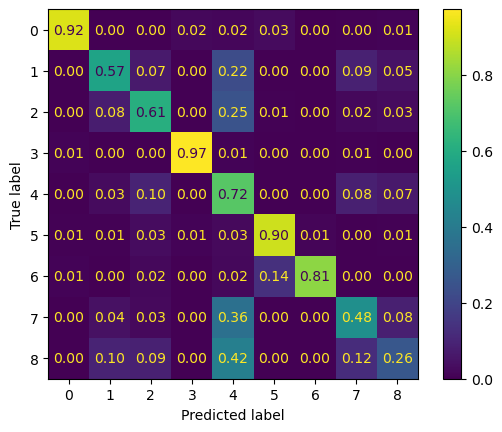

In [66]:
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=y_pred, normalize="true", values_format=".2f"
)

Notice that we see a some variability in the performance across classes. This is likely due to a class imbalance or inter-class differentiation challenge within our training dataset. It's possible that augmentations or class revision may help to address this. It's reccommended to view the CSV we created earlier (Vanuatu_ROIs.csv) to find out where there is imbalance.

Finally, save the model to file so that it can be loaded and reused again without needing to repeat training.

In [75]:
pickle.dump(clf, open(f"rf_vanuatu_lulc_{YEAR}_ROIversion{ROI_version}.pkl", "wb"))